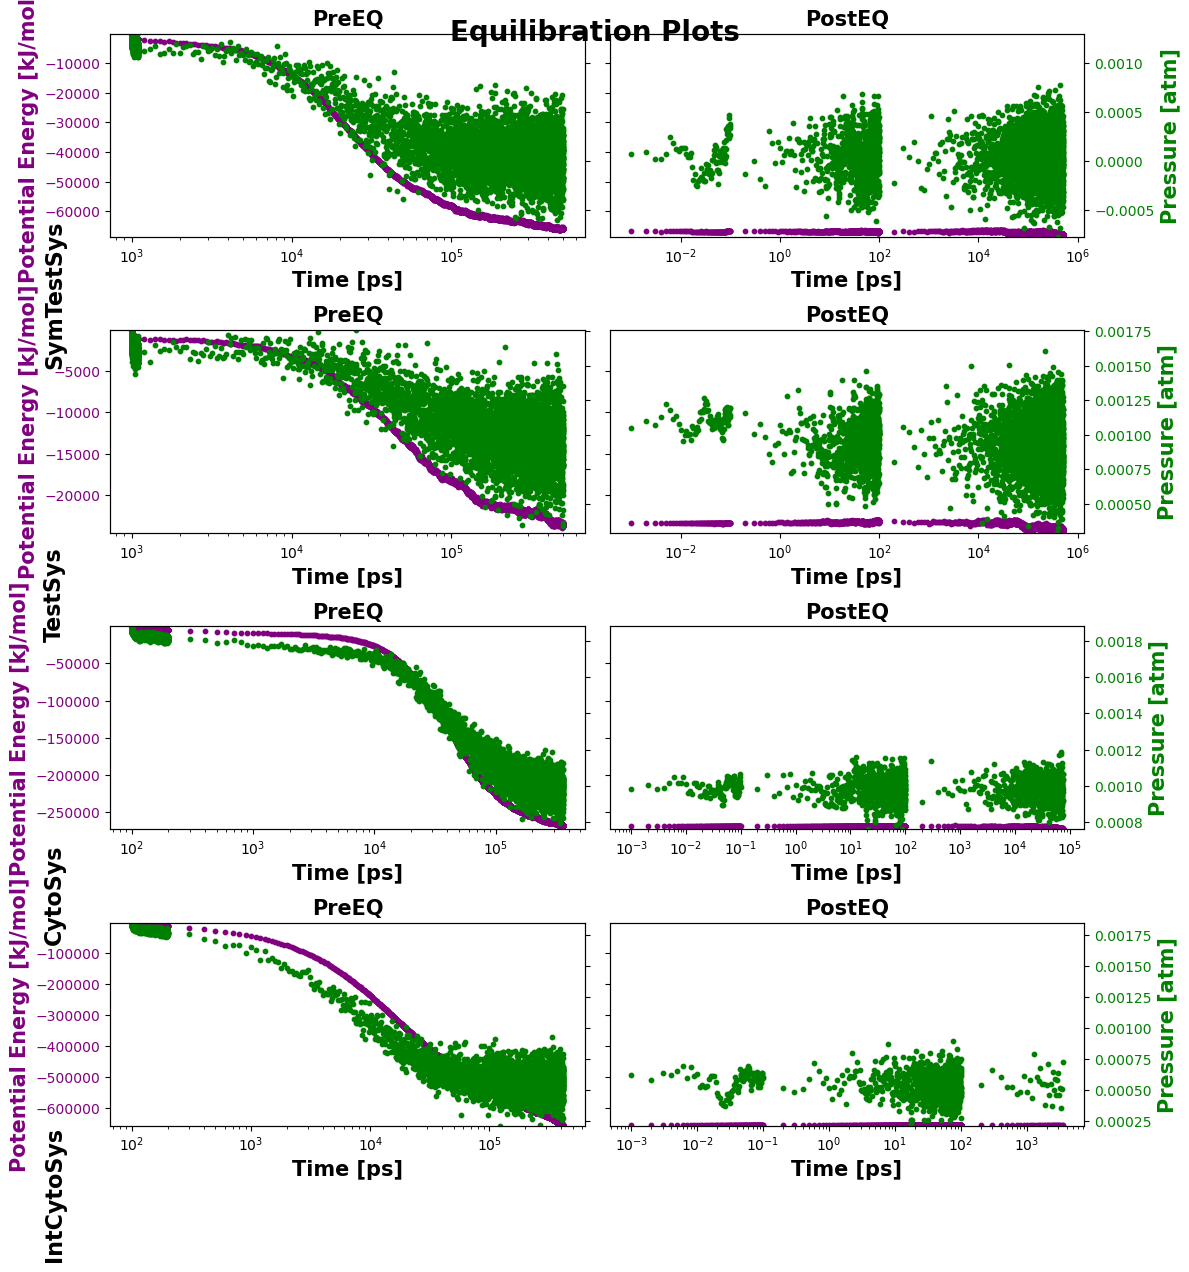

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Increase the font size and bold the text for titles and axis labels globally
plt.rcParams.update({
    'axes.titlesize': 15,  # Increase the font size of the title
    'axes.titleweight': 'bold',  # Bold the title font
    'axes.labelsize': 15,  # Increase the font size of the axis labels
    'axes.labelweight': 'bold',  # Bold the axis label font
    'grid.alpha': 0.5,  # Set grid line transparency
    'legend.fontsize': 12  # Set the legend font size
})

# Define the order explicitly as requested
systems = ['SymTestSys', 'TestSys', 'CytoSys', 'IntCytoSys']

# Define a function to load and process data
def load_and_process_data(system, data_type, phase):
    filename = f'./{system}_{data_type}_trajectory_{phase}.csv'
    if os.path.exists(filename):
        data = pd.read_csv(filename)
        if phase == 'PostEQ' and data_type in ['Energies', 'ThermodynamicQuantities']:
            # Adjust the time for PostEQ phase
            data['Time [ps]'] -= data['Time [ps]'].iloc[0]
        return data
    else:
        return None

# Initialize the figure with 4 rows of 2 columns, using a more visually appealing size
fig, axs = plt.subplots(len(systems), 2, figsize=(12, 3 * len(systems)))

for index, system in enumerate(systems):
    # Determine y-axis limits
    energy_limits = [np.inf, -np.inf]
    pressure_limits = [np.inf, -np.inf]

    for phase in ['PreEQ', 'PostEQ']:
        energies = load_and_process_data(system, 'Energies', phase)
        thermo = load_and_process_data(system, 'ThermodynamicQuantities', phase)
        
        # Update limits
        if energies is not None:
            energy_limits[0] = min(energy_limits[0], energies['Potential Energy [kJ/mol]'].min())
            energy_limits[1] = max(energy_limits[1], energies['Potential Energy [kJ/mol]'].max())
        if thermo is not None:
            pressure_limits[0] = min(pressure_limits[0], thermo['Pressure'].min())
            pressure_limits[1] = max(pressure_limits[1], thermo['Pressure'].max())

    for phase_index, phase in enumerate(['PreEQ', 'PostEQ']):
        energies = load_and_process_data(system, 'Energies', phase)
        thermo = load_and_process_data(system, 'ThermodynamicQuantities', phase)

        ax = axs[index, phase_index]
        color_energy = 'purple'
        color_pressure = 'green'

        if energies is not None and thermo is not None:
            ax.scatter(energies['Time [ps]'], energies['Potential Energy [kJ/mol]'], color=color_energy, label='Potential Energy', s=10)
            ax.set_xlabel('Time [ps]')
            ax.set_xscale('log')

            ax_twin = ax.twinx()
            ax_twin.scatter(thermo['Time [ps]'], thermo['Pressure'], color=color_pressure, label='Pressure', s=10)
            
            # Apply the determined limits
            ax.set_ylim(energy_limits)
            ax_twin.set_ylim(pressure_limits)
            
            if phase_index == 0:  # Pre EQ
                ax.set_ylabel('Potential Energy [kJ/mol]', color=color_energy)
                ax.tick_params(axis='y', labelcolor=color_energy)
                ax_twin.set_yticklabels([])  # Hide the right y-axis labels for Pre EQ
            else:  # Post EQ
                ax_twin.set_ylabel('Pressure [atm]', color=color_pressure)
                ax_twin.tick_params(axis='y', labelcolor=color_pressure)
                ax.set_yticklabels([])  # Hide the left y-axis labels for Post EQ
            
            ax.set_title(f'{phase}', fontsize=15, fontweight='bold')
            
    # Add system name label to the left of the row, spanning across Pre EQ and Post EQ plots
    fig.text(0.04, 0.75 - (index * 0.25), system, va='center', rotation='vertical', fontsize=16, fontweight='bold')

plt.tight_layout()
fig.suptitle('Equilibration Plots', fontsize=20, fontweight='bold')
plt.savefig('./combined_stats_continuous.svg', format='svg')
plt.show()
